# PyTorch for Beginners

During this course we will be making use of PyTorch to construct and use deep neural networks. As we cannot be sure if everyone is at the same level with using this framework, we created this notebook to get you familiar with some of the basics. This way you can play around with the framework and probably ask more detailed questions when you get stuck. The topic of deep neural networks is not an easy one and as you might know there are entire courses on it. Do not expect that this tutorial notebook is complete and you might find more information in other sources. We will try to provide good sources for you to begin with. 

The goal of this notebook is for you to get familiar with some of the basics of PyTorch. Also for you to be able to design  different kinds of deep neural networks and train and test them on one of the most famous beginner datasets named MNIST. More information on this dataset will follow. 

At the end of this notebook you will construct a submission file for the MNIST focused *Getting Started Prediction Competition* on Kaggle named [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/overview). We included this part in the notebook as we think it is a fun way to learn to use PyTorch. The instructions throughout the notebook will explain how to create a Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN) to be able to come up with your first predictions. You are then free to mess around with the data, network or training settings to improve your predictions. Maybe augment the data or add more layers to your network.

**Note:** The focus of this notebook is on using PyTorch and **not** on understanding every step of applying deep learning. If any part not related to PyTorch (e.g. preprocessing or use of specific loss function) is unclear, do not panic as we will not expect that you know everything on this matter. Try to understand how to use the PyTorch framework.

**Sources:**

- [MNIST - PyTorch for Beginners (Detailed Desc)](https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc/notebook)

- [Introduction to PyTorch](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)

## Imports

First lets import the necessary packages. You can import PyTorch with `import torch` and more specific for computer vision related tasks `import torchvision`. PyTorch also has an entire submodule dedicated to neural networks, called `torch.nn`. [Here](https://pytorch.org/docs/stable/nn.html) you can find building blocks needed to construct all sorts of neural network architectures. There is also a torch submodule containing optimization algorithm classes named `torch.optim` and a submodule that provides many functions that work like the modules we find in `torch.nn` but named `torch.nn.functional`. In the latter you can find the functional counter part of `nn.Linear` which is `nn.functional.linear`.

We also include two imports from the scikit-learn package `sklearn`. This is an open source data analysis library often used for machine learning in Python. You can use it to preprocess data or even to use known algorithms for classification or regression. As this notebook focuses on PyTorch for machine learning we will simply use the `sklearn` package for preprocessing our data.

In [1]:
#PyTorch Specific libraries
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets

#Data manipulation and visualisation specific libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For splitting the data into Train and Test set
from sklearn.model_selection import train_test_split

# For normalizing data
from sklearn import preprocessing

## GPU vs CPU

One important feature of PyTorch is the suppport of GPUs, short for Graphics Processing Unit. To check the main differences between GPU and CPU, check out the following blog by [Kevin Krewell, 2009](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/). In short: GPU perform many small operations in parallel, making it suitable for performing large matrix operations in neural networks. You can also read more details on GPUs in this [Intel blog](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html).

PyTorch implements a lot of functionality for supporting GPUs, but of course you should have a GPU available. The code block below checks this. If you do have a suitable GPU available (please check your device specifications) but the code below still prints 'cpu', you should check if you have CUDA correctly [installed](https://www.google.com/search?q=how+to+install+cuda) and otherwise ask one of us for help.

In [2]:
# This piece of code is required to make use of the GPU instead of CPU for faster processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#If it prints "cuda:0" that means it has access to GPU. If it prints out "cpu", then it's still running on CPU.

cpu


By default all tensors created are stored on the CPU. You can manually push a tensor to the GPU by using the function `.to(...)` or `.cuda()`. However, it is good practice to define a `device` object like we did in the code block above which points to the GPU if you have one, and otherwise to the CPU. Then you can use your code on both a CPU-only system and one with GPU without having to change anything when switching systems. To then push a tensor to the device write this:

In [3]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]])


One more important note on GPUs and CPUs is that when generating random numbers the seed between CPU and GPU is not synchronized. You will need to set the seed on the CPU separately to ensure a reproducible code. It could still be that running the same code on different CPUs does not guarantee the same random numbers due to different GPU architectures. You can set the seed on the GPU with the following code:

In [4]:
# GPU operations have a separate seed we also want to set
if torch.cuda.is_available(): 
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    
# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data

You are going to use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits. The original training set has 60.000 examples and a test set of 10.000 examples, both contain 28x28 black and white images representing the digits from 0 to 9. Like mentioned on the Kaggle overview page of the competition, this dataset is kind of a 'hello world' dataset of computer vision. The task is very straightforward: you will train a neural network to correctly identify digits from the handwritten images. 

### Load Data

You could download the original training and test set, however, Kaggle has its own training and test splits so if we would use the original sets we would introduce test examples into the training set. This will cause unreliable results and is probably the reason that some people obtain a accuracy score of 100% on the public leaderboard. [Chris Deotte](https://www.kaggle.com/competitions/digit-recognizer/discussion/61480) explains this in the discussion part of the Kaggle competition. He also explains how to obtain certain scores, which could be useful at the end of this notebook if you decide to improve your own predictions.

For now, just download the Kaggle sets from this [link](https://www.kaggle.com/competitions/digit-recognizer/data) to start. Unzip the file and place the files somewhere and use the exact path to load the files with the code below:

In [10]:
train = pd.read_csv('../DataSets/MNIST/train.csv')
test = pd.read_csv('../DataSets/MNIST/test.csv')

#Let's check if they have been loaded properly
print('train.shape:\n', train.shape)
print('test.shape:\n', test.shape)

train.shape:
 (42000, 785)
test.shape:
 (28000, 784)


In [ ]:
# train = pd.read_csv('./digit-recognizer/train.csv')
# test = pd.read_csv('./digit-recognizer/test.csv')

# #Let's check if they have been loaded properly
# print('train.shape:\n', train.shape)
# print('test.shape:\n', test.shape)

### Split Data

#### Splitting features and target variables

The first column of the train set contains the label and the other columns are all the features. Here variable `X` will contain the features and variable `y` the labels.

In [12]:
X = train.iloc[:,1:]
y = train.iloc[:,:1] #Could have done like this 
y = train.label.values # but needed to convert it to np.ndarray for torch tensor conversion

As you can see there are two ways of obtaining the labels. Either by using `train.iloc[:,:1]` or by using `train.labels.values`. The difference is that the former results in a Series object and the latter results in a ndarray. We want a ndarray since we want to convert this into a PyTorch Tensor.

In [13]:
print('X.shape: ', X.shape, 'X.type: ', type(X) )
print('y.shape: ', y.shape, 'y.type: ', type(y) )

X.shape:  (42000, 784) X.type:  <class 'pandas.core.frame.DataFrame'>
y.shape:  (42000,) y.type:  <class 'numpy.ndarray'>


#### Split the data into train and test sets

You might think why do we need to split the data into a train and test set, did we not already do this? The reason is that we will need another *test* set for validation during the training proces. The original test set does not contain labels and so we do not know if our model made correct predictions if we use it on this set. 

We will split the training set (which contains labels) into a training and test set so that we can use its labels for validating the predictions during training. To do so the `train_test_split()` [method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from `sklearn.model_selection` is used. This method takes in the features (X) and label column (y) separately in the first 2 parameters. The 3rd parameter is `test_size`, which we can set in order to specify with what percentage we want to split our data. By setting it to `0.1` we will split the data into 90% training and 10% test. The last parameter is the `random_state`, which is an optional parameter used to eliminate any 'randomness' and make sure we produce the same results over multiple runs. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.1, random_state = 1)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

X_train.shape:  (37800, 784)
y_train.shape:  (37800,)
X_test.shape:  (4200, 784)
y_test.shape:  (4200,)


## Visualizing Data

An important step in an image classification task is to look at the data, make sure it is loaded correctly and then make any initial observations about patterns in that data.

We will make use of the `matplotlib` library to plot the images.

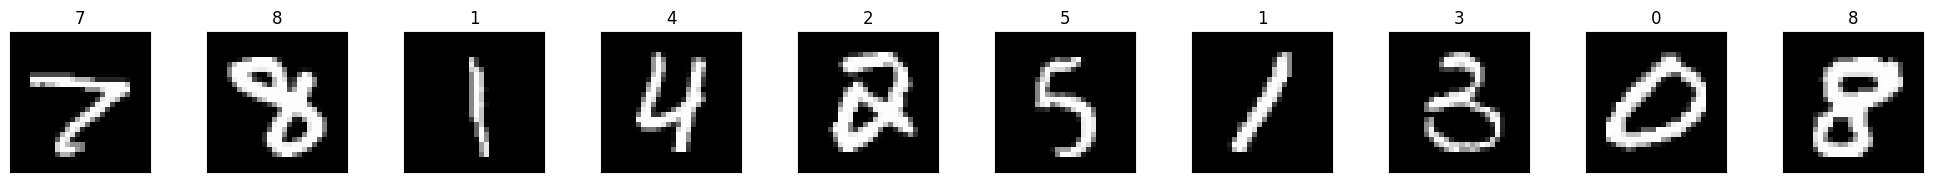

In [15]:
# obtain one batch of training images
images, labels = X_train[:10], y_train[:10]
images = images.iloc[:,:].values

# making sure we can view the images
images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

#### View an Image in More Detail

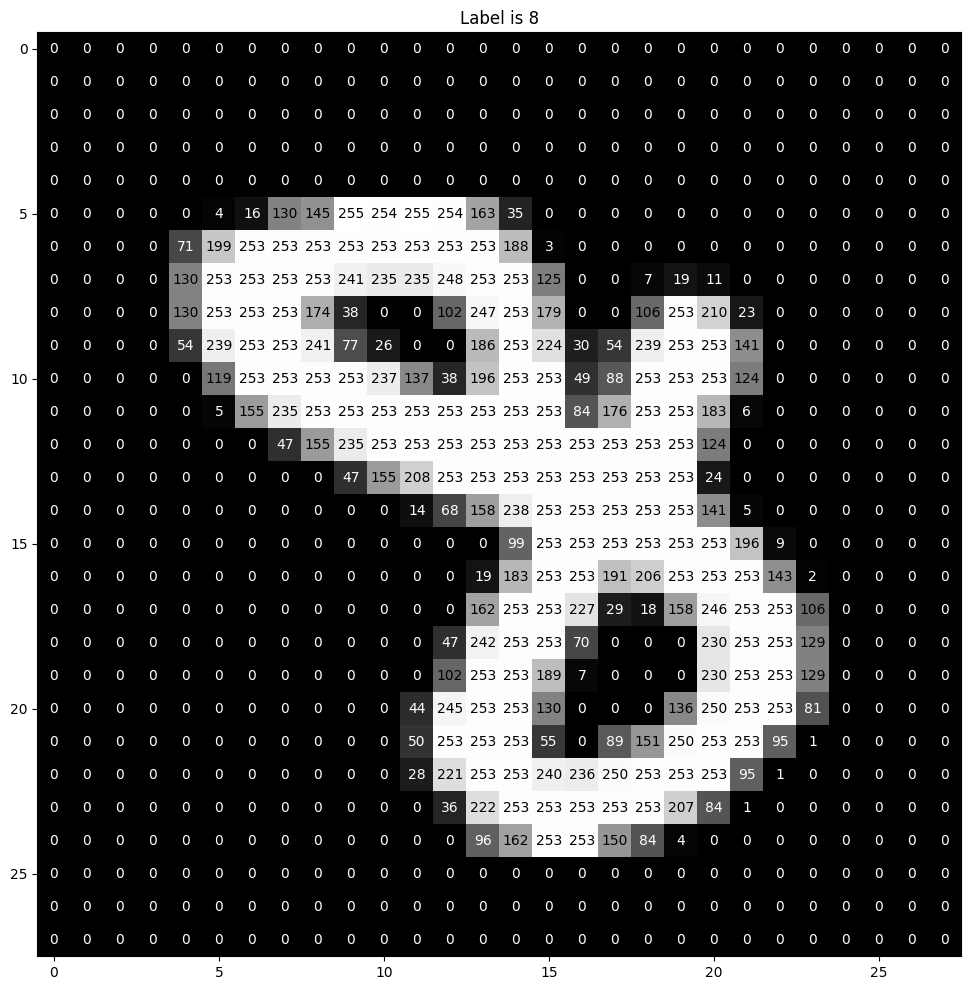

In [16]:
# Use squeeze to remove axes of length one so from (28, 28, 1) --> (28, 28)
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
ax.set_title(f"Label is {str(labels[1].item())}")

# annotate each pixel in the image with its value
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
plt.show()

## Preprocessing Data

### Rescaling values

The pixel values of the original dataset are in the range of (0,255). For a neural network to be efficient, we will rescale these values to (0,1). All the values will be rescaled to be between 0 and 1. 

With this example we know that the range is of (0,255) and so we could simply rescale the values by dividing by 255.

In [17]:
#Rescaling values
X_train_rescaled = X_train.values/255
X_test_rescaled = X_test.values/255

We could also use the scikit-learn `preprocessing.MinMaxScaler()` [function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) to rescale our data. This function will rescale the data to a specific range. The default range is set to (0,1), but you can pass along another range as tuple (min,max) to the parameter `feature_range`:

In [18]:
scaler = preprocessing.MinMaxScaler()
X_train_scikit = scaler.fit_transform(X_train.values)
X_test_scikit= scaler.fit_transform(X_test.values)

In [19]:
print(f"X_train_rescaled min: {np.min(X_train_rescaled)}, max: {np.max(X_train_rescaled)}")
print(f"X_test_rescaled min: {np.min(X_test_rescaled)}, max: {np.max(X_test_rescaled)}")

X_train_rescaled min: 0.0, max: 1.0
X_test_rescaled min: 0.0, max: 1.0


In [20]:
print(f"X_train_scikit min: {np.min(X_train_scikit)}, max: {np.max(X_train_scikit)}")
print(f"X_test_scikit min: {np.min(X_test_scikit)}, max: {np.max(X_test_scikit)}")

X_train_scikit min: 0.0, max: 1.0
X_test_scikit min: 0.0, max: 1.0


In [21]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,100))
X_train_scikit0_100 = scaler.fit_transform(X_train.values)
X_test_scikit0_100 = scaler.fit_transform(X_test.values)

In [22]:
print(f"X_train_scikit0_100 min: {np.min(X_train_scikit0_100)}, max: {np.max(X_train_scikit0_100):.2f}")
print(f"X_test_scikit0_100 min: {np.min(X_test_scikit0_100)}, max: {np.max(X_test_scikit0_100):.2f}")

X_train_scikit0_100 min: 0.0, max: 100.00
X_test_scikit0_100 min: 0.0, max: 100.00


While the default `preprocessing.MinMaxScaler()` might seem to normalize data, normalizing data is not simply scaling the values to fall between 0 and 1. With normalization you scale vectors individually to a unit norm so that the vector has length of one. You can perform this action with another scikit-learn [function](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) named `preprocessing.normalize()`. Here the default norm for scaling vectors is the L2 norm also known as the Euclidean norm (square root of the sum of the squares of each value).

In [23]:
# Example normalization
x_array = np.array([2,3,5,6,7,4,8,7,6])

normalized_arr = preprocessing.normalize([x_array])
print(x_array)

# The output shows that all the values are in the range 0 to 1
print(normalized_arr)

# if you square each value in the output and then add them together, the result is 1, or very close to 1.
length = 0.0
for v in normalized_arr[0]:
    length += v**2
print(f"{length:.2f}")

# example output computation
sum_squares_values = np.sum([x**2 for x in x_array])
print(f"Sum of the squeres of each value: {sum_squares_values}")
sqrt_sum_squares_values = np.sqrt(sum_squares_values)
print(f"Square root of the sum of the squares of each value: {sqrt_sum_squares_values}")
manually_normalized_arr = [round(x/sqrt_sum_squares_values,8) for x in x_array]
print(manually_normalized_arr)

[2 3 5 6 7 4 8 7 6]
[[0.11785113 0.1767767  0.29462783 0.35355339 0.41247896 0.23570226
  0.47140452 0.41247896 0.35355339]]
1.00
Sum of the squeres of each value: 288
Square root of the sum of the squares of each value: 16.97056274847714
[0.11785113, 0.1767767, 0.29462783, 0.35355339, 0.41247896, 0.23570226, 0.47140452, 0.41247896, 0.35355339]


We will only rescale the MNIST data for now.

Lets keep the variable naming short for the remaining of this notebook:

In [24]:
X_train = X_train.values/255
X_test = X_test.values/255

### Torch Tensors

PyTorch works with tensors and thus we will need to convert the data. With the function `torch.from_numpy()` you can convert a NumPy array or a Panda's dataframe to Torch Tensor (remember why we needed 'y' to be a NumPy array and not series).

In [25]:
#Converting to Tensors
X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

print('X_train.dtype:', X_train.dtype)
print('X_test.dtype:', X_test.dtype)
print('y_train.dtype:', y_train.dtype)
print('y_test.dtype:', y_test.dtype)

X_train.dtype: torch.float64
X_test.dtype: torch.float64
y_train.dtype: torch.int64
y_test.dtype: torch.int64


In [26]:
print(X_train.requires_grad)
print(X_test.requires_grad)
print(y_train.requires_grad)
print(y_test.requires_grad)

False
False
False
False


As you can see from the output above the tensors have `requires_grad` set to `False`. While we do need to compute gradients during training and so we would like for our tensors to have this attribute set to `True`, this is implicitly done by PyTorch. The [default mode](https://pytorch.org/docs/stable/notes/autograd.html) is `grad mode` and so when a function is applied on an input tensor it will switch this attribute to `True` unless we specify differently. So for now don't worry about this attribute.

## Dataset and DataLoader

**Sources:**

- [Data Loading Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

- [Data Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

When working with neural networks you want to provide the right amount of balanced data and because you often work with large datasets this work could become messy very easily. Luckily, PyTorch provides two modules that can be used to handle datasets and data loading: `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. They allow you to use pre-loaded datasets or your own data as `Dataset` stores the samples and their corresponding labels and `DataLoader` wraps an iterable around the `Dataset` to enable easy loading of samples. 

One more reason to use these modules is that datasets can sometimes have large amounts of records and loading them all at once would be very difficult. Here a technique called `batching` can be used, which means that you access records in batches instead of all at once.

**Batch:** Small set of the larger dataset.

**iteration:** 1 `batch` has completed 1 iteration when it has finished going from the input layer to the output layer.

**epochs:** When every record of the dataset is passed through the network, then the network is said to have finished 1 `epoch`.

Below, we will make our own dataset using `TensorDataset` and set the batch size to `100`. 

With the help of the DataLoader class, we will make a `train_loader` and `test_loader`. The `shuffle` parameter is set to `True` to specify that the records in a particular batch need to be randomly selected from the entire dataset and not selected in the original order as they appear.


In [27]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)

batch = 100

# Set our data loaders
train_loader = torch.utils.data.DataLoader(train, batch_size = batch, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch, shuffle = True)

### Visualize a Batch of Training Data

Here we show how to visualize a batch of training data using the DataLoader class. We need to transform our data a bit as we did some preprocessing in the previous steps.

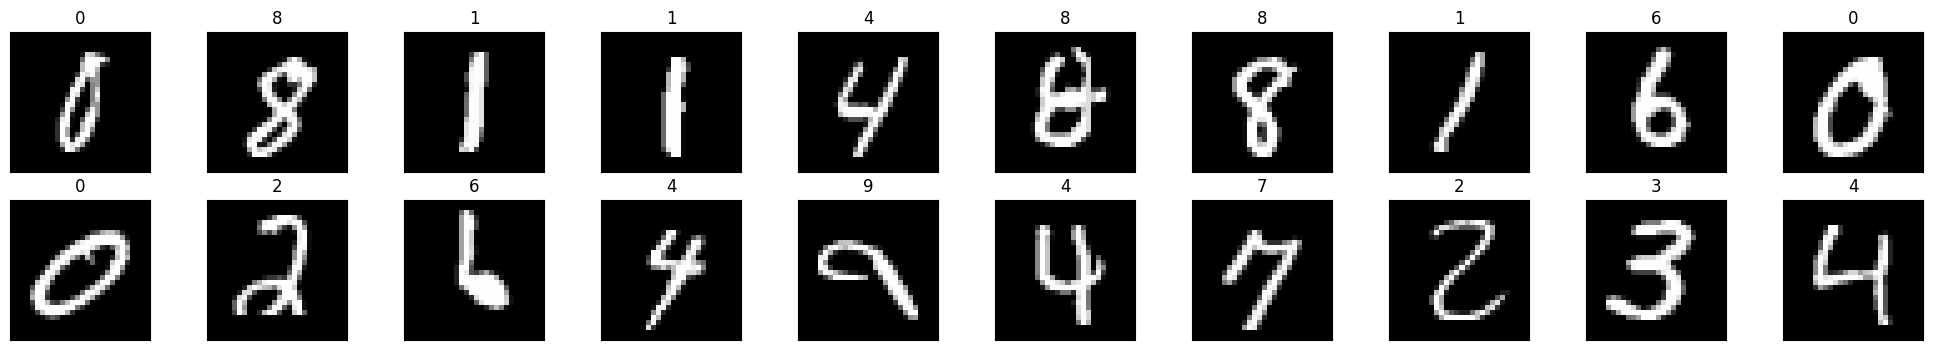

In [28]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.detach().numpy()

# making sure we can view the images
images = images*255
images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx], cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Network

Next we will define our neural network architecture using PyTorch modules. In the next code cells:

- `Net()`: is the main class which inherits from `nn.Module` class. The latter is a base class for all neural network modules. Our `Net()` class has the methods `__init__()` and `forward()`. 
- `__init__()`: the `__init__()` method, which is one of the 'special methods' that are part of Python, can be seen as some sort of constructor method. It stands for initalisation and as the name tells it is used to initialize everything in the class. It will inherit all the properties of the `nn.Module`'s own `__init__()` method when we write `super().__init__()`. All the different layers are defined in this method.
- `forward()`: this method sets the course of our network and use all the layers that we have defined in the `__init__()` method. 

When we make a new object of class `Net()`, the init method will be called and everything will be initialized. When we then use the object of class `Net()` on data, the forward method will be executed on it.

### Define Multilayer Perceptron Architecture

The example architecture we will use in text:

- `Layer 1: Linear Layer 1 > Activation Function (ReLU) > Dropout Layer 1`
- `Layer 2: Linear Layer 2 > Activation Function (ReLU) > Dropout Layer 2`
- `Layer 3: Output Layer`

In [29]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

#Making an object of the Net class
mlp_model = MLP().to(device)
print(mlp_model)

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Define Convolutional Neural Network Architecture

The example architecture we will use in text:

- `Layer 1: Convolution Layer 1 > Activation Function (ReLU) > Pooling Layer 1 > Dropout Layer 1`
- `Layer 2: Convolution Layer 2 > Activation Function (ReLU) > Pooling Layer 2 > Dropout Layer 2`
- `Flatten the output from layer 2.`
- `Layer 3: Linear Layer 1 > Activation Function (ReLU) > Dropout Layer 3`
- `Layer 4: Linear Layer 2 > Activation Function (ReLU) > Dropout Layer 4`
- `Layer 5: Output Layer > Activation Function (Softmax)`

A convolutional neural network has multiple hidden layers and usually contains a:
1) Convolution Layer
2) ReLU Layer
3) Pooling Layer
4) Fully Connected Layer

In [30]:
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 128, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(p=0.3)
        
        self.conv2 = nn.Conv2d(128, 224, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.fc3 = nn.Linear(224*4*4, 64)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.fc4 = nn.Linear(64, 32)
        self.drop4 = nn.Dropout(p=0.4)
        
        self.fc5 = nn.Linear(32, 10)
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        x = self.drop1(self.pool1(F.relu(self.conv1(x))))
        x = self.drop2(self.pool2(F.relu(self.conv2(x))))
        x = x.view(-1,224*4*4)
        x = self.drop3(F.relu(self.fc3(x)))
        x = self.drop4(F.relu(self.fc4(x)))
        x = self.softmax(self.fc5(x))
        return x

cnn_model = CNN().to(device)
print(cnn_model) 

CNN(
  (conv1): Conv2d(1, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(128, 224, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=3584, out_features=64, bias=True)
  (drop3): Dropout(p=0.4, inplace=False)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


The following Q&A is copied directly from the [Kaggle notebook](https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc/notebook) we have been following along. It explains certain decisions with regard to the network architecture and will probably help to understand how to use PyTorch to build your own network. We do, however, recommend that you check the official [PyTorch documentation](https://pytorch.org/docs/stable/index.html) to see what options you have when constructing your own network. Here you can find, among other things, other layer types and what parameters they expect. 

**Q. Why these many layers? Why not less or more?**

A. Choosing the number of layers is up to the network designer (you). It's with trial and error that you develop an intiution of how many layers (or neurons) a particular problem may require to get to the desired solution. You can play with the number of layers and neurons (numbers like 128, 224 etc) and see how the network is responsding to your changes.

**Q. What does Conv2d(1, 128, 5) actually mean?**

A. [Conv2d()](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) is a function that helps create a convolution layer. The three paramteres mentioned (in order) are: input_channels, output_channels and kernel_size.

**input_channels:** input_channels refers to the number of channels the input has. If our dataset contained colored images, this argument would have been equal to 3. But our dataset contains only the black and white pictures (more generally called as the grayscale images), so a grayscale images have only 1 channel. Hence the argument is equal to 1.

**output_channels:** output_channels is arbitrary number and can be set to any number you want. It basically sets the number of neurons that its input_channels would be connected to. It also sets the input_channels of the next convolution layer. So, `output_channel (previous layer) = input_channel (next layer)`

**kernel_size:** kernel_size is a square matrix of a particular width and height. When we set the third parameter to 5, it basically means we are setting the square kernel of size 5 x 5. A kernel can be thought of as a window (matrix) that slides over our image to extract certain features out of it in order to learn. That's why kernels are also called as feature maps.

There's another parameter that we haven't explicitly defined but by default is set to 1, and that is **'stride'**. A [stride](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) means by how much the kernel should slide in order to output the next feature map. `stride = 1` essentially means that it will slide by 1 pixel to right and 1 pixel to down.

**Q. What is pooling?**

A. Pooling is another type of layer in a neural network that down samples the feature maps created by the convolution layer. It basically summarises a portion of the image in a much lesser space. It is done to reduce variance and computations. But why [max-pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)? It's because max-pooling helps in extracting low-level features like edges, points, etc. There are other type of pooling methods such as average pooling and others.

**Q. What is the importance of view() function in the forward() method?**

A. The view() function takes in a tensor (for ex a 4D tensor) and outputs a lower dimensional tensor (for example a 1D tensor). This is required because the next set of layers are the linear layers. And linear layers only accept a 1D tensor (a "flattened" array) as an input. So, the view function is used to flatten the tensor so that it can then be fed to the linear layers.

**Q. What is a Dropout Layer?**

A. To help understand what [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) really is, we need to understand what regularisation in general is

**Regularization**

Regularization helps to solve over fitting problem in machine learning. It is nothing but adding a penalty term to the objective function and control the model complexity using that penalty term.

Too complex?

For now, consider it as something that tells our model to not cross a certain boundry (threshold). Because if it does, it will be overfitted. Overfiting is a problem that machine learning algortihms face when the model is 'too exact' to be used for actual real world data. That simply means that our model, when overfitted, wouldn't be accurate in preidction task when a new datapoint is fed into the model (for example a datapoint from the test dataset). So, in order to avoid overfitting, we use regularization. This is just an intuition. We don't need to get into the math of anything for now.

Dropout is one of the regularization methods. Dropout helps avoid overfitting by simply 'switching off' some of the neurons in a particular iteration. Sometimes, the output of a particular neuron from a particular layer can shoot off to a high value or to a very low value. So, the dropout method helps the network to consider some of the other neurons that it might have been ignoring because of their lower valued outputs. So, by simply turning off some neurons, it makes sure that it takes into account every neuron and hence train in a more vigorous manner and hence avoid overfitting.

**Q. What is ReLU and Softmax?**

A. ReLU is short for Rectified Linear Unit. ReLU and Softmax are both activation functions. What are activation functions, you ask? Well, they can be thought of as something that restricts the values of the neurons after computations to explode to extremes (very high negative or very high positive) values. Activation functions makes sure the values are bounded within a range. For example, the ReLU function makes sure the values are between (0,max(val)) range, where 'val' is the actual value of the neuron.

**Q. But why are only ReLU and Softmax chosen?**

A. You can choose any activation function you want [[non-linear activations (weighted sum, nonlinearity)](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity), [non-linear activations (other)](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other)]. However, ReLU has proven to perform well in almost all the cases as compared to other activation functions. `tanh` is another very commonly used activation function. We don't have the luxury of choosing just any activation function when it comes to the output layer. We want to choose an activation function according to our desired output. We have chosen softmax because softmax gives out a class score for every class which is basically a probablity distribution that in turn tells us how confident is the neural network about a certain class to be the actual output.

**Note:** The two modules imported from the torch library: nn and functional can be used interchangeable. Having said that, all the functions that are present in the nn module are there in the functional module as well. The only difference is the names of these funtions.

For example, Max pooling function from the functional module can be called as:

`F.max_pool2d(x, kernel_size, stride)`

and from the nn module:

`nn.MaxPool2d(kernel_size, stride)`

Why are there two implementations of the same things? It's to suit the coding style of different people. Some prefer a stateful approach while others prefer a more functional approach.

More information and building blocks can be found on [pytorch.org/docs/stable/nn.html](https://pytorch.org/docs/stable/nn.html).

### Define Loss Function

We need a loss function to calculate the prediction error of the network. With this function we can calculate which weight should be adjusted with what particular value. There are many [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) that can be used, where for classification problems the two most common ones are Cross Entropy Loss and NLL Loss. You can experiment with the function to see which one is more benificial for your problem. A good starting point to figure out which loss function you could use for which problem is this [guide](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/).

During this tutorial we will make use of Cross Entropy Loss.

In [31]:
#Loss function
criterion = nn.CrossEntropyLoss()

### Define Optimizer

An optimizer ties the loss function and model parameters together by updating the model in response to the output of the loss criterion. We will be using [Adam](https://pytorch.org/docs/stable/optim.html#algorithms) as our optimizer with a learning rate of 0.0015. This value is experimental. The learning rate is one of those parameters that are changable. After a while dealiing with and constructing neural networks, you'll develop an intiution of which values could possibly work for a particular problem. Otherwise, you can always decide to keep an additional set of data (validation set) aside to optimize these kind of parameters. 

In [32]:
# Optimizer
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr = 0.0015)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr = 0.0015)

## Train the Neural Network

Now we will start training our neural networks. We wrote some code for training in the code block below, where all code is nicely placed in one method so that you can call the same code for different models. It has some default settings for `epochs`, `steps` and `print_every`. 

In [33]:
def model_training(model,criterion,optimizer,epochs=30,steps=0,print_every=100):
    trainLoss, testLoss = [], []
    for e in range(epochs):
        running_loss = 0
        for images, labels in train_loader:
            steps += 1   # Forward pass
            images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
            optimizer.zero_grad()
            log_ps = model(images.type(torch.FloatTensor).to(device))
            labels = labels.to(device)
            loss = criterion(log_ps, labels)
            loss.backward()   # Backward pass
            optimizer.step()

            running_loss += loss.item()
            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0

                with torch.no_grad():
                    model.eval()
                    for images, labels in test_loader:
                        images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
                        log_ps = model(images.type(torch.FloatTensor).to(device))
                        labels = labels.to(device)
                        test_loss += criterion(log_ps, labels)
                        ps = torch.exp(log_ps)

                        top_p, top_class = ps.topk(1, dim = 1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor))

                model.train()

                trainLoss.append(running_loss/len(train_loader))
                testLoss.append(test_loss/len(test_loader))

                print("Epoch: {}/{}.. ".format(e + 1, epochs),
                      "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    return (trainLoss, testLoss)

#### Notes

Again, the following information is copied directly from the [Kaggle notebook](https://www.kaggle.com/code/amsharma7/mnist-pytorch-for-beginners-detailed-desc/notebook) we have been following along. It explains some of the (PyTorch) code from the above code block.

We are using a `for` loop to go through a total of 30 epochs.

The `images` tensor is a 2D tensor, we first convert it into a 4D tensor since our neural network (the Net() class) requires it to be a 4D tensor. Hence we use the `view()` function.

`optimizer.zero_grad()` sets all the gradient's values to zero. It's an essential step while training the network.

`log_ps = model(images.type(torch.FloatTensor))` simply gives a set of images to the network for training. Here the set is of 100, as we set it earlier while defining the DataLoader

`loss = criterion(log_ps, labels)` compare the predicted and the actual labels and calculates the loss.

`loss.backward()` is the step where the network starts backpropagating in order to adjust the weights and other parameters of the network and start the training process all over again.

*Please note that the loss is calculated by the loss function but the weights are updated only during backpropagation.*

`running_loss += loss.item()` is used to calculate `trainLoss` which eventually would be helpful in plotting the graph of training and validation loss

Since we don't want every iteration to get printed on the screen, we only want every 100th iteration to get prinited with the accuracy score, hence we have used an `if` statment for the same.

`with torch.no_grad()`: the `with` keyword is an elegant way of handling exceptions in python. The wrapper `torch.no_grad` temporarily sets all the `requires_grad` flag to false. Eventually, it will reduce the memory usage and speed up computations. While we did not explicitly set the tensor attribute `requires_grad` to true, this was implicitly done during the forward pass as the [default mode](https://pytorch.org/docs/stable/notes/autograd.html) is grad mode and we need to use `torch.no_grad()` to switch from this default mode. 

`model.eval()` it indicates the model that nothing new is to be learnt and the model is used for testing.

`torch.exp(log_ps)` returns a new tensor with the exponential of the elements of the input tensor

`ps.topk(1, dim = 1)` returns a sparse copy of the tensor

`labels.view(*top_class.shape)` sees how many of the classes were correct

`torch.mean(equals.type(torch.FloatTensor))` calculate the mean (gets the accuracy for this batch) and add it to the running accuracy for this epoch

`model.train()` tells your model that you are training the model. So effectively, layers like dropout etc, which behave different on the train and test procedures, know what is going on and hence can behave accordingly.


### MLP Training

In [34]:
mlp_trainLoss, mlp_testLoss = model_training(mlp_model,criterion,mlp_optimizer)

Epoch: 1/30..  Test Accuracy: 0.922
Epoch: 1/30..  Test Accuracy: 0.938
Epoch: 1/30..  Test Accuracy: 0.957
Epoch: 2/30..  Test Accuracy: 0.959
Epoch: 2/30..  Test Accuracy: 0.958
Epoch: 2/30..  Test Accuracy: 0.962
Epoch: 2/30..  Test Accuracy: 0.964
Epoch: 3/30..  Test Accuracy: 0.967
Epoch: 3/30..  Test Accuracy: 0.964
Epoch: 3/30..  Test Accuracy: 0.968
Epoch: 3/30..  Test Accuracy: 0.971
Epoch: 4/30..  Test Accuracy: 0.967
Epoch: 4/30..  Test Accuracy: 0.972
Epoch: 4/30..  Test Accuracy: 0.973
Epoch: 4/30..  Test Accuracy: 0.976
Epoch: 5/30..  Test Accuracy: 0.976
Epoch: 5/30..  Test Accuracy: 0.973
Epoch: 5/30..  Test Accuracy: 0.977
Epoch: 6/30..  Test Accuracy: 0.963
Epoch: 6/30..  Test Accuracy: 0.974
Epoch: 6/30..  Test Accuracy: 0.978
Epoch: 6/30..  Test Accuracy: 0.976
Epoch: 7/30..  Test Accuracy: 0.978
Epoch: 7/30..  Test Accuracy: 0.976
Epoch: 7/30..  Test Accuracy: 0.975
Epoch: 7/30..  Test Accuracy: 0.972
Epoch: 8/30..  Test Accuracy: 0.976
Epoch: 8/30..  Test Accuracy

#### Plot Training Loss

Let's now visualize the training and validation loss:

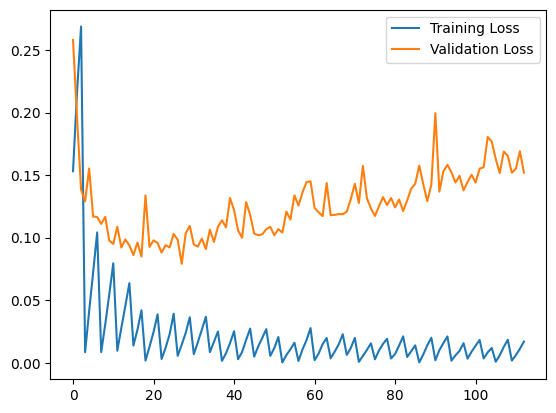

In [35]:
mlp_testLoss = [loss.cpu() for loss in mlp_testLoss]

%matplotlib inline

plt.plot(mlp_trainLoss, label = 'Training Loss')
plt.plot(mlp_testLoss, label = 'Validation Loss')
plt.legend(loc=1)

Plotting training and validation loss is important to understand how your model is performing on the data and what actions you can take to improve performance. This [link](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/) explaines the learning curves in more detail.

### CNN training

In [36]:
cnn_trainLoss, cnn_testLoss = model_training(cnn_model,criterion,cnn_optimizer)

Epoch: 1/30..  Test Accuracy: 0.807
Epoch: 1/30..  Test Accuracy: 0.935
Epoch: 1/30..  Test Accuracy: 0.948
Epoch: 2/30..  Test Accuracy: 0.956
Epoch: 2/30..  Test Accuracy: 0.960
Epoch: 2/30..  Test Accuracy: 0.959
Epoch: 2/30..  Test Accuracy: 0.955
Epoch: 3/30..  Test Accuracy: 0.968
Epoch: 3/30..  Test Accuracy: 0.970
Epoch: 3/30..  Test Accuracy: 0.960
Epoch: 3/30..  Test Accuracy: 0.964
Epoch: 4/30..  Test Accuracy: 0.970
Epoch: 4/30..  Test Accuracy: 0.970
Epoch: 4/30..  Test Accuracy: 0.972
Epoch: 4/30..  Test Accuracy: 0.972
Epoch: 5/30..  Test Accuracy: 0.974
Epoch: 5/30..  Test Accuracy: 0.973
Epoch: 5/30..  Test Accuracy: 0.959
Epoch: 6/30..  Test Accuracy: 0.973
Epoch: 6/30..  Test Accuracy: 0.971
Epoch: 6/30..  Test Accuracy: 0.971
Epoch: 6/30..  Test Accuracy: 0.970
Epoch: 7/30..  Test Accuracy: 0.975
Epoch: 7/30..  Test Accuracy: 0.975
Epoch: 7/30..  Test Accuracy: 0.977
Epoch: 7/30..  Test Accuracy: 0.978
Epoch: 8/30..  Test Accuracy: 0.974
Epoch: 8/30..  Test Accuracy

#### Plot Training Loss

Let's now visualize the training and validation loss:

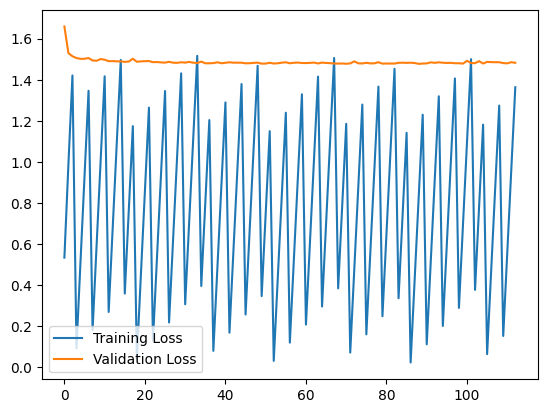

In [37]:
cnn_testLoss = [loss.cpu() for loss in cnn_testLoss]

%matplotlib inline

plt.plot(cnn_trainLoss, label = 'Training Loss')
plt.plot(cnn_testLoss, label = 'Validation Loss')
plt.legend(loc=3)

## Test Network

After succesfully training our model we can test it on the actual test set to get predictions. We do not have the labels of images in the test set so we cannot calculate our loss on this set. We can, however, make a submission file that includes our prediction for each image and then submit this on Kaggle to get a score. The code below will help to compute the predicitions and create a submission file for Kaggle.

### Predict the labels on actual test data

In [39]:
test = pd.read_csv('../DataSets/MNIST/test.csv')

finalTest = test.values/255

finalTest = torch.from_numpy(finalTest)

temp = np.zeros(finalTest.shape)
temp = torch.from_numpy(temp)

data = torch.utils.data.TensorDataset(finalTest, temp)

submissionLoader = torch.utils.data.DataLoader(data, batch_size = batch, shuffle = False)

In [40]:
def model_testing(model):
    submission = [['ImageId', 'Label']]
    
    with torch.no_grad():
        model.eval()
        image_id = 1
        for images, _ in submissionLoader:
            images = (images.view(-1,1,28,28)).type(torch.DoubleTensor)
            log_ps = model(images.type(torch.FloatTensor).to(device))
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim = 1)

            for prediction in top_class:
                submission.append([image_id, prediction.item()])
                image_id += 1
    
    return submission

In [41]:
mlp_submission = model_testing(mlp_model)
cnn_submission = model_testing(cnn_model)

Let's plot a batch of the test set and display the predictions from the MLP and CNN models. You can use the method below that includes similar code as the visualization code from earlier in this notebook.

In [42]:
def show_submission_predictions(submission,suptitle):
    # obtain one batch of submission images
    dataiter = iter(submissionLoader)
    images, _ = next(dataiter)
    images = images.detach().numpy()

    # making sure we can view the images
    images = images*255
    images = [image.astype(np.uint8).reshape((28, 28, 1)) for image in images]

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    st = fig.suptitle(suptitle, fontsize="x-large")
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
        ax.imshow(images[idx], cmap='gray')
        # print out the correct label for each image
        # .item() gets the value contained in a Tensor
        ax.set_title(str(submission[idx+1][1]))

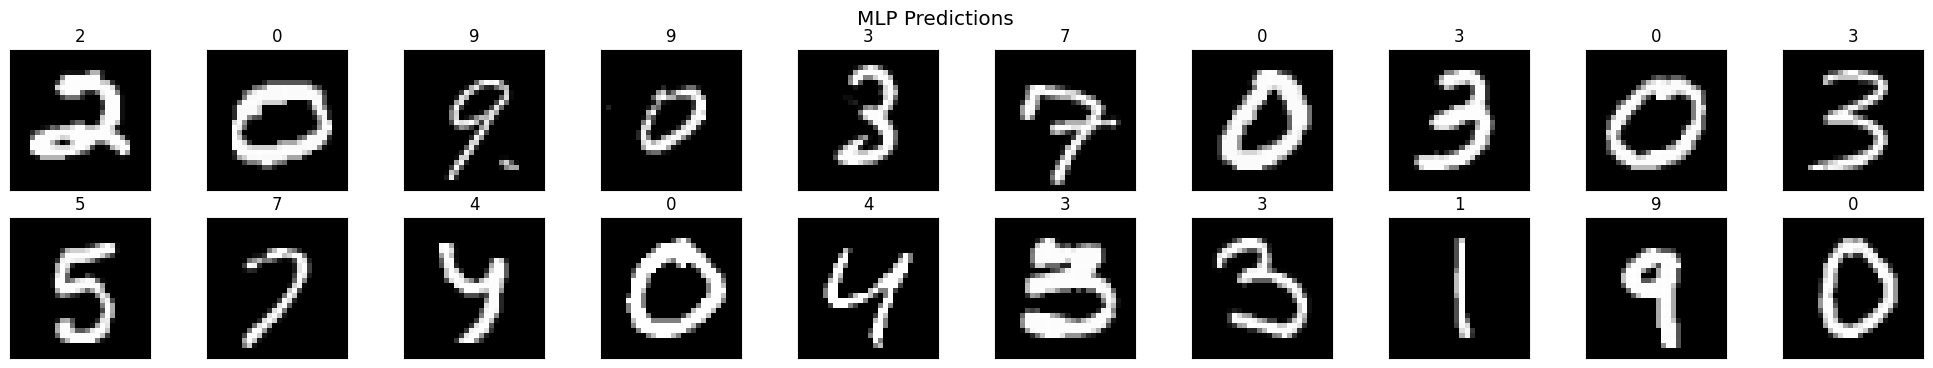

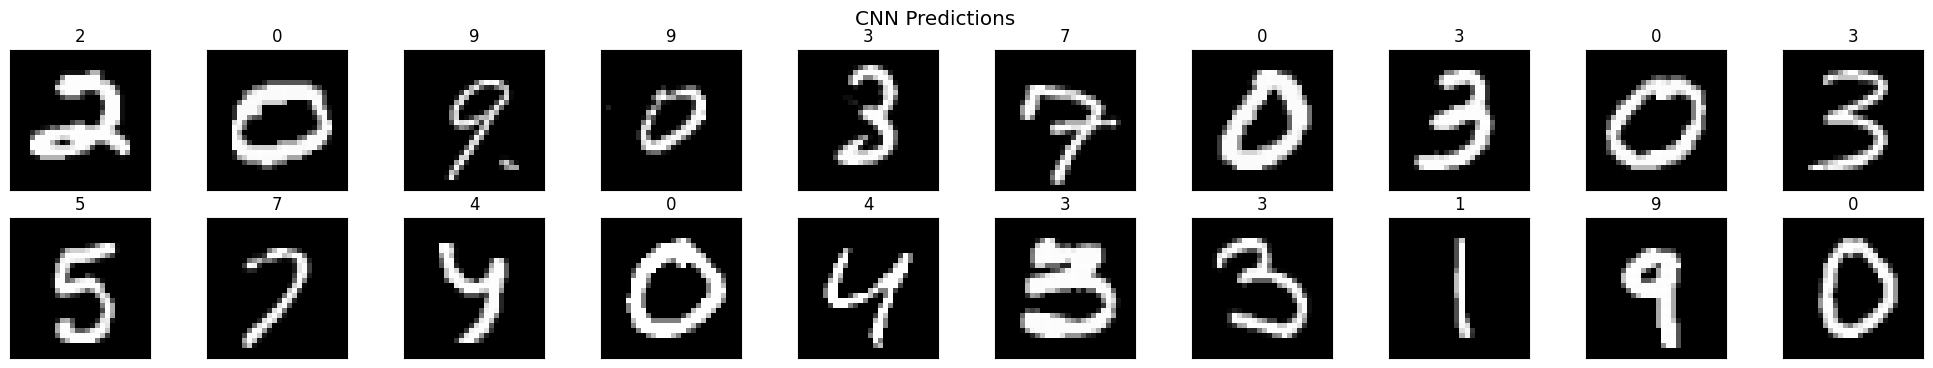

In [43]:
show_submission_predictions(mlp_submission,"MLP Predictions")
show_submission_predictions(cnn_submission,"CNN Predictions")

### Make Kaggle Submission

Now if you want you can use the code below to create submission files for the Kaggle competition [Digit Recognizer](https://www.kaggle.com/competitions/digit-recognizer/overview). Login or create an account at Kaggle and head over to the competition page where you can submit the files created below. You will get a score on the leaderboard.

In [44]:
def create_submission_file(submission,filename):
    pytorchSubmission = pd.DataFrame(submission)
    pytorchSubmission.columns = pytorchSubmission.iloc[0]
    pytorchSubmission = pytorchSubmission.drop(0, axis = 0)

    pytorchSubmission.to_csv(filename, index = False)

In [45]:
create_submission_file(mlp_submission,"mlp_submission.csv")
create_submission_file(cnn_submission,"cnn_submission.csv")

Submit the file to [Kaggle](https://www.kaggle.com/competitions/digit-recognizer/overview) to see your score. In order to improve your score you have multiple options:
- augment the data
- train with more epochs
- optimize hyperparameters (such as learning rate)
- try out other loss or activation functions
- try out a different network architecture
- add more layers
- etc...

Like we mentioned above, a good start might be the discussion page written by [Chris Deotte](https://www.kaggle.com/competitions/digit-recognizer/discussion/61480). You could create a new notebook or just continue below the final section on saving models. Copy any part from above to get started, check the official [PyTorch documentation](https://pytorch.org/docs/stable/index.html) for the options you have (e.g., different activation functions) and start experimenting to improve your score on Kaggle.

**But first let us explain one final important thing: saving and loading models.**

### Saving a model

After you are finished training a model, you can save the model to disk so that you can load the same weights at a later time. You should extract the so-called `state_dict` from the model which contains all learnable parameters.

In [ ]:
state_dict = cnn_model.state_dict()
print(state_dict)

To save the dictionary, you can use `toch.save`:

In [ ]:
# torch.save(object, filename). For the filename, any extension can be used
torch.save(state_dict, "our_cnn_model.tar")

To load a model from a state dict, you can use the function `torch.load` to load the state dict from the disk, and the module function `load_state_dict` to overwrite our parameters with the new values:

In [ ]:
# Load state dict from the disk (make sure it is the same name as above)
state_dict = torch.load("our_cnn_model.tar")

# Create a new model and load the state
new_model = CNN()
new_model.load_state_dict(state_dict)

# Verify that the parameters are the same
print("Original model\n", cnn_model.state_dict())
print("\nLoaded model\n", new_model.state_dict())

More information on saving and loading models can be found [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

## Improve Submission

In [ ]:
# add your own code here